In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib widget # not sure what this does...not in my env
from scipy import signal
import os
from tqdm import trange # for progress bars in loops
from skimage.color import rgb2hsv, rgb2gray
from skimage.filters import threshold_otsu

In [2]:
def array2list(a):
    if a.__class__ is np.ndarray:
        list(a)
    return a
    
def list2array(a):
    if a.__class__ is list:
        np.array(a)
    return a

def zeroD_2_oneD_array(a):
    if np.ndim(a) == 0:
        a = np.array(a)[np.newaxis]
    return a

def resize_text(ax, fntsz=8):
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fntsz)
    for item in ([ax.title]):
        item.set_fontsize(fntsz)

def find_bar_only(img, Shoreline_Index=150):
    from skimage.color import rgb2hsv, rgb2gray
    import numpy as np
    import pandas as pd
    from scipy import signal
    import copy
    gray = np.array(rgb2gray(img), dtype=float)
    BAR_STATS = pd.DataFrame({'Row' : pd.Series([], dtype=int),
                    'BAR_N' : pd.Series([], dtype=int),
                    'Crest_IX' : pd.Series([], dtype=int)}) 
    
    #for px in trange(np.size(gray,axis=0)):
    for px in range(np.size(gray,axis=0)):
        
        if np.size(Shoreline_Index)>1: #Check if Shoreline is scalar or vector
            SL_IX = Shoreline_Index[px]
        else:
            SL_IX = copy.deepcopy(Shoreline_Index)
            
        DF = pd.DataFrame({'D': pd.Series(np.linspace(0, np.shape(img)[1], np.shape(img)[1]+1), dtype=float),
                        'Z_gray': pd.Series(gray[px,::]/np.nanmax(gray[px,::]), dtype=float)})

        wndl = 5
        DF['Zs_gray'] = np.concatenate((np.repeat(np.nan, np.floor(wndl/2).astype(int)),
                                         np.convolve(np.repeat(1,wndl).astype(float), DF.Z_gray, 'valid')/wndl, 
                                         np.repeat(np.nan, np.floor(wndl/2).astype(int))))
        DF['Zs_gray'] = DF['Zs_gray'].fillna(DF.Z_gray).interpolate()
        
        peaks_crest, _ = signal.find_peaks(DF['Zs_gray'], prominence=0.1)
        bar_crest_possibilities = peaks_crest[peaks_crest>SL_IX]

        first_bar = np.nan
        second_bar = np.nan
        extra_bars = zeroD_2_oneD_array(np.nan)
            
        if np.size(bar_crest_possibilities)>=1:
            first_bar = bar_crest_possibilities[0]
            if np.size(bar_crest_possibilities)>=2:
                second_bar = bar_crest_possibilities[1]
                if np.size(bar_crest_possibilities)>=3:
                    extra_bars = zeroD_2_oneD_array(bar_crest_possibilities[2::])
            
        BAR_STATS = BAR_STATS.append({'Row' : px,
                        'BAR_N' : np.size(bar_crest_possibilities),
                        'First_Bar_IX': first_bar,
                        'Second_Bar_IX': second_bar,
                        'Extra_Bars_IX': extra_bars,
                        'Crest_Dist_offshore_pixels': first_bar - SL_IX}, ignore_index=True)    
    return BAR_STATS

In [3]:
def sort_labels(labels):
    label_nums = np.unique(labels)
    label_size = np.zeros(len(label_nums))
    for i,label_num in enumerate(label_nums):
        label_size[i]= len(labels[labels==label_num])
    
    sorted_labels = label_nums[np.argsort(-label_size)]
    sorted_size = label_size[np.argsort(-label_size)]
    return sorted_labels, sorted_size

Load Images

In [52]:
#img_path = r'C:\crs\proj\2019_CACO_CoastCam\samples_for_tim'
img_path = r'C:\crs\proj\2019_CACO_CoastCam\Caco-01_rectified'

#img_path = r'E:\Nearshore Bars\samples_for_tim'
imgs = [f for f in os.listdir(img_path) if f.endswith('.jpg')]
# imgs = os.['1582309801.jpg','1603564201.jpg', '1604840401.jpg','1604325601.jpg']
print('Found {} files'.format(len(imgs)))

Found 7489 files


Good info  on cluster analysis here: https://scikit-learn.org/stable/modules/clustering.html

In [60]:
%%time
from coastcam_funcs import *

from scipy.interpolate import interp1d

from sklearn.cluster import OPTICS, cluster_optics_dbscan
clust = OPTICS(min_samples=15, xi=.05, min_cluster_size=.05)

anis_fac = 0.25
eps = 20.

# locations where bar distances will be interpolated
start_row = 200
end_row = 650
ylocs = np.arange(start_row+5., end_row-5., 5.)

# array for storing bar distances
bdata = np.ones((len(ylocs),len(imgs)))
etime = np.ones(len(imgs))

for ic,im in enumerate(imgs):

    img = plt.imread(os.path.join(img_path,im))
    ftime, etime[ic] = filetime2timestr(im, timezone='eastern')

    BAR_STATS = find_bar_only(img[start_row:end_row,:,:], Shoreline_Index=178)
    
    # put output into 2D array, remove NaNs, correct row offset
    bar1 = BAR_STATS[['Row','First_Bar_IX']].to_numpy()
    bar1=bar1[~np.isnan(bar1).any(axis=1)].copy()
    bar2 = BAR_STATS[['Row','Second_Bar_IX']].to_numpy()
    bar2=bar2[~np.isnan(bar2).any(axis=1)].copy()
    bar = np.concatenate((bar1,bar2))
    bar[:,0]= bar[:,0]+start_row

    if(bar.size>300):

        # scale for anisotropy
        barscl = bar.copy()
        barscl[0,:]=barscl[0,:]*anis_fac
    
        # Run the fit
        clust.fit(barscl)
 
        labels = cluster_optics_dbscan(reachability=clust.reachability_,
                                           core_distances=clust.core_distances_,
                                           ordering=clust.ordering_, eps=eps)
    
        sorted_labels, sorted_size = sort_labels(labels)

        # longest bar
        bc = bar[labels == sorted_labels[0],:]

        # smooth with 11-point running mean
        N = 11
        bc[:,1] = np.convolve(bc[:,1], np.ones(N)/N, mode='same').copy()
       
        # interpolate to ylocs, save in array
        f = interp1d(bc[:,0],bc[:,1],bounds_error=False,fill_value=np.NaN,)
        bci = f(ylocs)
        bdata[:,ic] = bci

Wall time: 5h 39min 53s


In [70]:
# quick save 
np.save('bdata',bdata)
np.save('etime',etime)

In [4]:
# reload
start_row = 200
end_row = 650
ylocs = np.arange(start_row+5., end_row-5., 5.)
etime = np.load('etime.npy')
bdata = np.load('bdata.npy')

In [34]:
from coastcam_funcs import *
dto = np.zeros((len(etime)), dtype='datetime64[s]')
for i in np.arange(len(etime)):
    ets = str(int(etime[i]))
    _, dto[i] = unix2dts(ets)

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


At y=505.0, mean bar location is :222.0


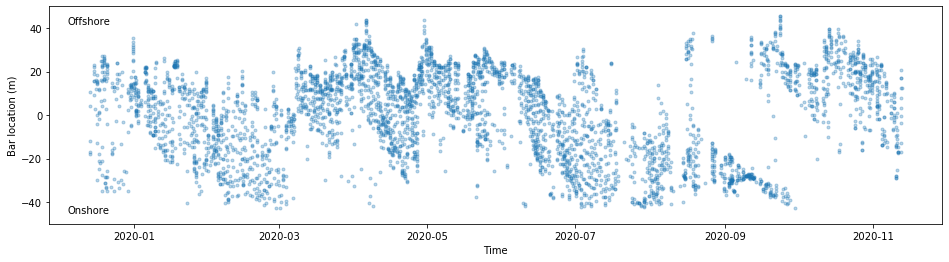

In [52]:
bdata[np.where(bdata<10.)]=np.nan
mbar = np.nanmean(bdata[60,:])
print('At y={}, mean bar location is :{:.1f}'.format(ylocs[60],mbar))
fig,ax = plt.subplots(figsize=(16,4))
et = (etime-etime[0])/(24*60*60)
#plt.plot(et[:],bdata[20,:],'.',alpha=.3)
plt.plot(dto[:],bdata[60,:]-mbar,'.',alpha=.3)
#plt.plot(et[:],bdata[80,:],'.',alpha=.3)
ax.set_ylim([-50,50])
plt.ylabel('Bar location (m)')
plt.xlabel('Time')
ax.text(.02,.05,'Onshore',transform=ax.transAxes)
ax.text(.02,.92,'Offshore',transform=ax.transAxes)
plt.savefig('bar_timeseries.png',dpi=200)

In [51]:
print(np.array((.5, 1, 1.5, 2))*.78)

[0.39 0.78 1.17 1.56]


In [1]:
etime = np.load('etime.npy')
bdata = np.load('bdata.npy')


NameError: name 'np' is not defined